**Expectation-Maximization applied to a Gaussian mixture**

In this code, we are going to apply the EM algorithm to infer the parameters of a Gaussian Mixture. If you have any questions, you can contact the instructor.

The first thing we need to do is to import the necessary libraries. We will use numpy to generate the samples and matplotlib to plot the results. We will also use the magic command `%matplotlib inline` to show the plots in the notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we are going to generate the samples. We will consider a Gaussian mixture composed by two components, but you can change them if you want. Note that this part of the code is the same as in Example 1.7, which we have already seen.

In [11]:
# Parameters of the Gaussian mixture: put as many as you want
mu = np.array([0, 6])  # Means of each Gaussian
std = np.array([1, np.sqrt(2)])  # Standard deviation of each Gaussian
p = np.array([0.7, 0.3])  # Probability of sampling from each Gaussian: must add up to 1!

# Generate the samples!
n_samples = 5000  # Number of samples to generate
u = np.random.choice(p.size, size=n_samples, p=p)  # Generate the indexes of each Gaussian
gaussian_samples = np.random.randn(n_samples)  # Generate standard Gaussian samples
samples = gaussian_samples * std[u] + mu[u]  # Now, use u, as well as std and mu, to obtain the desired samples

In general, a mixture model assumes the data are generated by the following process: first we sample z, and then we sample the observables x from a distribution which depends on $z$, i.e.

$p_{\theta}\left(z,x\right)=p_{\theta}\left(z\right)p_{\theta}\left(x|z\right) $

In mixture models, $p_{\theta}\left(z\right)$ is always a multinomial distribution:

$p_{\theta}\left(z=k\right)=\pi_{k}, \quad \forall k\in\left\{ 1,\cdots,K\right\} ,\quad \sum_{k=1}^{K}\pi_{k}=1 $,
while $p_{\theta}\left(x|z\right)$ can take a variety of parametric forms, but for this example we will assume it is a Gaussian distribution.

We can compute the pdf over $x$ by marginalizing out $z$:

$p_{\theta}\left(x\right)=\sum_{z}p_{\theta}\left(z,x\right)=\sum_{k=1}^{K}p_{\theta}\left(z=k\right)p_{\theta}\left(x|z=k\right)=\sum_{k=1}^{K}\pi_{k}\mathcal{N}\left(x;\mu_{k},\sigma_{k}^{2}\right)$

Learning this model requires to know two sets of parameters (for single dimensional problems):

 * The mean $\mu_{k}$ and standard deviation $\sigma_{k}^{2}$ associated with each component $k$.

 * The mixing proportions $\pi_{k}$, defined as $p_{\theta}\left(z=k\right)$

The calculation using the standard MLE is unaffordable while the E-M algorithm is much more convenient. If we remember the main equations

$\begin{array}{ccc}
E-\text{step}\colon & \text{Compute\,\,\,} & q_{i}\left(z^{\left(i\right)}\right)=p_{\theta}\left(z^{\left(i\right)}|x^{\left(i\right)};\theta^{\mathrm{old}}\right),\,\forall i\\
M-\text{step}\colon & \text{Evaluate} & \theta^{\mathrm{new}}=\underset{\theta}{\text{argmax}}Q\left(\theta,\theta^{\mathrm{old}}\right)
\end{array}$

where

$Q\left(\theta,\theta^{\mathrm{old}}\right)=\overset{N}{\underset{i=1}{\sum}}\int p_{\theta}\left(z^{\left(i\right)}|x^{\left(i\right)};\theta^{\mathrm{old}}\right)\ln p_{\theta}\left(x^{\left(i\right)},z^{\left(i\right)};\theta\right)dz^{\left(i\right)}=\sum_{i=1}^{N}\sum_{k=1}^{K}p_{\theta}\left(z^{\left(i\right)}=k|x^{\left(i\right)};\theta^{\mathrm{old}}\right)\ln p_{\theta}\left(x^{\left(i\right)},z^{\left(i\right)}=k;\theta\right)=\sum_{i=1}^{N}\sum_{k=1}^{K}p_{\theta}\left(z^{\left(i\right)}=k|x^{\left(i\right)};\theta^{\mathrm{old}}\right)\times\left(\ln p_{\theta}\left(x^{\left(i\right)}\mid z^{\left(i\right)}=k;\theta\right)+\ln p_{\theta}\left(z^{\left(i\right)}=k;\theta\right)\right)$

As shown in the slides, the E-step is given by computing $r_{k}^{\left(i\right)}$, the posterior probability of each sample belonging to each component of the mixture. This is given by:

$r_{k}^{\left(i\right)}=\frac{\pi_{k,\mathrm{old}}\mathcal{N}\left(x^{\left(i\right)};\mu_{k,\mathrm{old}},\sigma_{k,\mathrm{old}}^{2}\right)}{\sum_{l=1}^{K}\pi_{l,\mathrm{old}}\mathcal{N}\left(x^{\left(i\right)};\mu_{l,\mathrm{old}},\sigma_{l,\mathrm{old}}^{2}\right)}$

Regarding the M-step, we can solve the optimization problem as shown in the slides to obtain the parameters of the Gaussian mixture as follows:

 * $\pi_{k}=\frac{1}{N}\overset{N}{\underset{i=1}{\sum}}r_{k}^{\left(i\right)}$
 * $\mu_{k}=\frac{\overset{N}{\underset{i=1}{\sum}}r_{k}^{\left(i\right)}x^{\left(i\right)}}{\overset{N}{\underset{i=1}{\sum}}r_{k}^{\left(i\right)}}$
 * $\sigma_{k}^{2}=\frac{\overset{N}{\underset{i=1}{\sum}}r_{k}^{\left(i\right)}\left(x^{\left(i\right)}-\mu_{k}\right)^{2}}{\overset{N}{\underset{i=1}{\sum}}r_{k}^{\left(i\right)}}$

The next code is a direct implementation of these equations: in each iteration, we first obtain the posterior probabilities $r_{k}^{\left(i\right)}$ and then we update the parameters of the Gaussian mixture using the closed-form expressions shown above.

In [ ]:
# Implement E-M algorithm now
n_iter = 30  # Iterations of E-M algorithm
k = len(mu)  # Number of components of the Gaussian mixture (need to be known a priori)
mu_em = np.zeros((k, n_iter + 1))  # Mean values, to be computed in each iteration in the M-step
var_em = np.zeros((k, n_iter + 1))  # Variance values, to be computed in each iteration in the M-step
p_em = np.zeros((k, n_iter + 1))  # Mixing proportions, to be computed in each iteration in the M-step
mu_em[:, 0] = np.random.rand(k)  # Randomly initialize the mean values
var_em[:, 0] = np.random.rand(k)  # Randomly initialize the variance values
p_em[:, 0] = np.random.rand(k)
p_em[:, 0] = p_em[:, 0] / sum(p_em[:, 0])  # Randomly initialize the p values (note that they must add up to 1)

for i in range(n_iter):
    # E-step
    r = np.zeros((n_samples, k))  # Probability of each point belonging to each gaussian
    for sample in range(n_samples):
        for component in range(k):
            r[sample, component] = p_em[component, i] / (np.sqrt(2 * np.pi * var_em[component, i])) * np.exp(-0.5 * np.square(samples[sample] - mu_em[component, i]) / var_em[component, i])
    r = r / np.repeat(np.sum(r, axis=1).reshape([n_samples, 1]), k, axis=1)  # Normalize r (this step is the denominator of the expression of r)
    # M-step
    for component in range(k): # Update the values using the closed-form expresions
        p_em[component, i + 1] = np.sum(r[:, component]) / n_samples  # Mixing proportions update
        mu_em[component, i + 1] = np.sum(r[:, component] * samples) / np.sum(r[:, component])  # Mean values update
        var_em[component, i + 1] = np.sum(r[:, component] * np.square(samples - mu_em[component, i ])) / np.sum(r[:, component]) # Variance values update

Finally, we can plot the convergence of the parameters and the pdfs obtained with the E-M algorithm and compare them with the real ones. Note that the convergence is good enough to obtain a good approximation of the pdf.

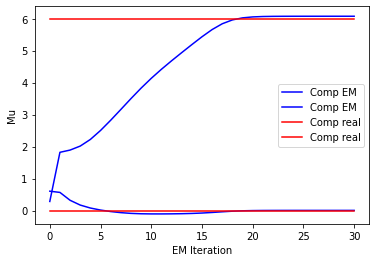

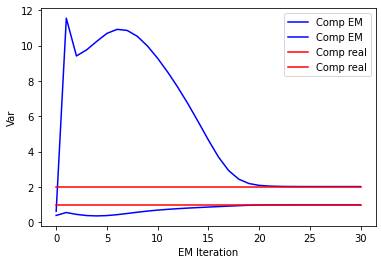

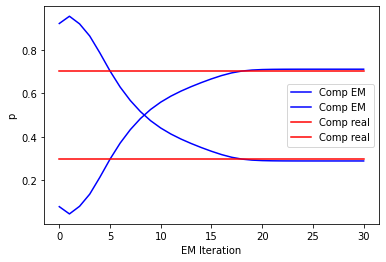

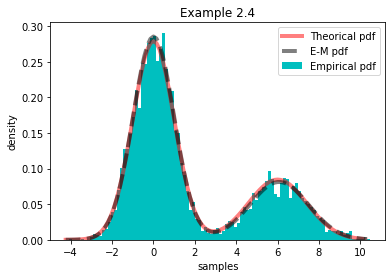

In [12]:
# Show the convergence of each component parameter
plt.plot(mu_em.T, color='b', label='Comp EM')
plt.plot(mu * np.ones((n_iter + 1, k)), color='r', label='Comp real')
plt.xlabel('EM Iteration')
plt.ylabel('Mu')
plt.legend(loc='best')
plt.show()

plt.plot(var_em.T, color='b', label='Comp EM')
plt.plot(np.square(std) * np.ones((n_iter + 1, k)), color='r', label='Comp real')
plt.xlabel('EM Iteration')
plt.ylabel('Var')
plt.legend(loc='best')
plt.show()

plt.plot(p_em.T, color='b', label='Comp EM')
plt.plot(p * np.ones((n_iter + 1, k)), color='r', label='Comp real')
plt.xlabel('EM Iteration')
plt.ylabel('p')
plt.legend(loc='best')
plt.show()

# Obtain empirical pdfs
x_min = np.amin(mu) - 3 * np.amax(std)  # Min value to obtain pdf
x_max = np.amax(mu) + 3 * np.amax(std)  # Max value to obtain pdf
x_range = np.linspace(x_min, x_max, 100)  # Range of values for plots
pdfs_real = np.array([1/(np.sqrt(2*np.pi) * std[i]) * p[i] * np.exp(-np.square((x_range - mu[i]) / std[i]) / 2 ) for i in range(p.size)])  # Compute the sum terms of the mixture
mix_pdf_real = np.sum(pdfs_real, axis=0)  # Compute the pdf of the real mixture (add the sum terms)
pdfs_em = np.array([1/(np.sqrt(2*np.pi * var_em[i,-1])) * p_em[i,-1] * np.exp(-np.square((x_range - mu_em[i,-1])) / (2 * var_em[i,-1]) ) for i in range(p.size)])  # Compute the sum terms of the mixture
mix_pdf_em = np.sum(pdfs_em, axis=0)  # Compute the pdf of the E-M mixture (add the sum terms)

# Show the pdfs obtained
plt.hist(samples, bins=100, density=True, color='c', label='Empirical pdf')  # Histogram: empirical pdf approximation
plt.plot(x_range, mix_pdf_real, color='r', linewidth=4, alpha=0.5, label='Theorical pdf')  # Theoretical pdf obtained before
plt.plot(x_range, mix_pdf_em, color='k', linewidth=4, alpha=0.5, linestyle='dashed', label='E-M pdf')  # E-M pdf obtained before
plt.xlabel('samples')
plt.ylabel('density')
plt.title('Example 2.4')
plt.legend(loc='best')
plt.show()
